# League Play
The basic self-play paradigm where an agent plays with/against (a clone of) itself can have issues solving a more complex environment. <br/>
For instance, some environments might have multiple optimal strategies. <br/>
By playing with yourself you will likely overfit on a single optimal strategy, resulting in poor peformance playing against/with other optimal strategies. <br/>
Moreover, self-play agents can forget how to play against/with sub-optimal strategies, even if those were encountered during training. <br/>

A learning paradigm that aims to overcome some of these challenges is called **league-play**. <br/>
Rather than training a single agent by playing with itself, league-play trains a league of multiple agents by training with each other. <br/>
In this notebook we will implement a basic league-play algorithm to learn to play the lever coordination game. <br/>

Let's start with importing some modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

from env.lever_game import LeverGame
from util.logger import Logger
from util.render import Renderer
from agents.qlearning import QLearning
from agents.exploration import LinearDecay

defining some hyper-parameters which we will use later

In [2]:
league_size = 4
total_episodes = 500
population = 30

# e-greedy hyperparameters
epsilon_start = 1
epsilon_end = 0.01
decayed_by = total_episodes / 2

and defining some utility functions for initializing a league and a population of leagues

In [3]:
def init_league(league_size, num_actions):
    league = []
    for _ in range(league_size):
        league.append(QLearning(1, num_actions))
    return league

def init_population(league_size, population_size, num_actions):
    leagues = []
    for _ in range(population_size):
        leagues.append(init_league(league_size, num_actions))
    return leagues

## Training
In this basic version of league-play, we start every training iteration by randomly sampling training pairs from our league

In [4]:
def sample_pairs(league):
    assert len(league) % 2 == 0, "League size should be even"
    
    shuffle = random.sample(league, len(league))
    pairs = []
    for i in range(0, len(league), 2):
        pairs.append((shuffle[i], shuffle[i+1]))
        
    return pairs

and letting the two players in a training pair play with each other

In [5]:
def joint_action(pair, state, episode, strategy):
    # player 1
    a1 = pair[0].select_action(state, epsilon=strategy.get_epsilon(episode))
    
    # player 2
    a2 = pair[1].select_action(state, epsilon=strategy.get_epsilon(episode))
    return (a1,a2)

Let's train a population of leagues and see how well they perform. <br/>
*Note that during every step we train all the agents in the league*

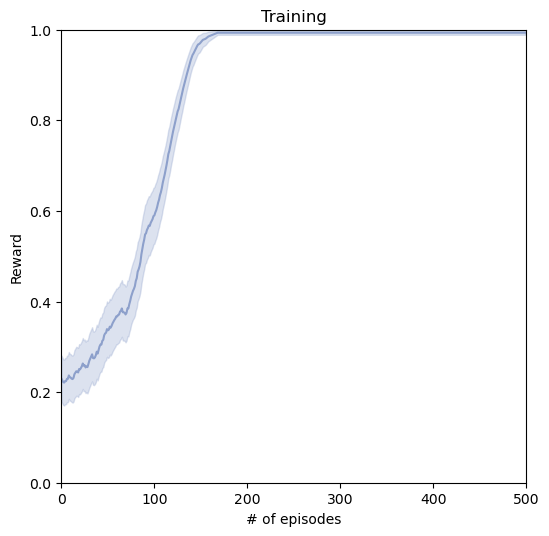

In [6]:
env = LeverGame()
log = Logger(population, total_episodes)

leagues = init_population(league_size, population, env.num_levers)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    for p in range(population):
        league = leagues[p]

        state = 0     # arbitrarily defined initial state

        # agents in the league play with each other in pairs
        pairs = sample_pairs(league)
        rewards = []
        for pair in pairs:
            action = joint_action(pair, state, episode, strategy)

            observation, reward, done, info = env.step(action)

            # our environment only has a single state
            next_state = state

            # train both agents in the pair
            pair[0].update_q_values(state, action[0], next_state, reward, done)
            pair[1].update_q_values(state, action[1], next_state, reward, done)

            # log training process
            _, r, _, _ = env.step((pair[0].get_optimal_action(state), pair[1].get_optimal_action(state)))
            rewards.append(r)

        # log training performance as the average reward of all the training pairs
        log.update_training_log(p, episode, np.array(rewards).mean())
            
log.show_results(smoothness=20)

Just like regular self-play, the agents seem to be able to converge to the maximum reward of 1 during training.

### Agent Visualisation
Let's visualise the Q values of our league-play agents during training to gain a better understanding in how they learn

In [11]:
render_interval = int(total_episodes / 100)
file_name = 'league_play'

env = LeverGame()
league = init_league(league_size, env.num_levers)
renderer = Renderer(total_episodes, league)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    state = 0     # arbitrarily defined initial state

    pairs = sample_pairs(league)

    for pair in pairs:
        action = joint_action(pair, state, episode, strategy)

        observation, reward, done, info = env.step(action)

        # our environment only has a single state
        next_state = state

        pair[0].update_q_values(state, action[0], next_state, reward, done)
        pair[1].update_q_values(state, action[1], next_state, reward, done)

    renderer.store_q_values(episode, league)           
    
renderer.render_q_values(file_name, render_interval)

In [8]:
from IPython.display import Markdown as md

# Display the gif created above
md(f'![](gif/{file_name}.gif)')

![](gif/league_play.gif)

Much like the self-play agent, the league-play agents eventually settle on a policy that always selects the same lever. <br/>
This leads to optimal performance during training when the agent only plays with other agents in its league. 

## Testing (Zero-Shot Coordination)
Just like the self-play agent, we are going to test our league agents in the zero-shot coordination setting. <br/>
In this setting we are evaluating our league-agents by pairing them with other (independently trained) league-play agents. 

In [9]:
def cross_play_testing(leagues):
    population = len(leagues)
    reward_matrix = np.zeros((population, population))
    
    state = 0
    
    for i1 in range(population):
        for i2 in range(i1):
            l1 = leagues[i1]
            l2 = leagues[i2]
            
            state = 0
            
            # get best agents from the leagues
            p1 = get_optimal_agent(l1, state)
            p2 = get_optimal_agent(l2, state)
            
            action = (p1.get_optimal_action(state), p2.get_optimal_action(state))
            _, r, _, _ = env.step(action)
            
            reward_matrix[i1,i2] = r
            
    # the reward matrix is symmetric
    reward_matrix = reward_matrix + np.transpose(reward_matrix)
    
    return reward_matrix

def get_optimal_agent(league, state):
    max_q_value = 0
    optimal_agent = None
    
    for agent in league:
        if agent.Q_values[state].max() > max_q_value:
            max_q_value = agent.Q_values[state].max()
            optimal_agent = agent
    
    return agent

Let's see how the league-play agents perform in the cross-play (zero-shot coordination) scenario

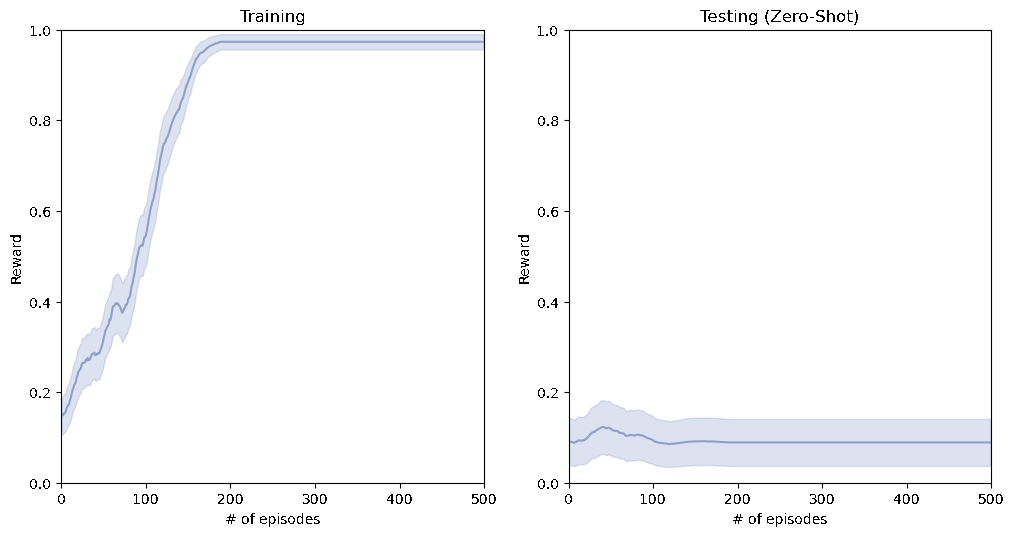

In [10]:
env = LeverGame()
log = Logger(population, total_episodes)

leagues = init_population(league_size, population, env.num_levers)
strategy = LinearDecay(epsilon_start, epsilon_end, decayed_by)

for episode in range(total_episodes):
    
    # Training
    for p in range(population):
        league = leagues[p]

        state = 0     # arbitrarily defined initial state

        pairs = sample_pairs(league)
        rewards = []

        for pair in pairs:
            action = joint_action(pair, state, episode, strategy)

            observation, reward, done, info = env.step(action)

            # our environment only has a single state
            next_state = state

            pair[0].update_q_values(state, action[0], next_state, reward, done)
            pair[1].update_q_values(state, action[1], next_state, reward, done)

            # log training process
            _, r, _, _ = env.step((pair[0].get_optimal_action(state), pair[1].get_optimal_action(state)))
            rewards.append(r)

        log.update_training_log(p, episode, np.array(rewards).mean())
                
    # Testing
    rewards = cross_play_testing(leagues)
    
    log.update_testing_log(episode, rewards)
            
log.show_results(smoothness=20)

Much like the self-play agents, the league-play agents perform poorly in the zero-shot coordination setting. <br/>
This is because settling on a policy that always selects the same lever, doesn't work if the other leagues settle on different levers. 